In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

In [2]:
def plot_causal_graph(adj_matrix, factor_list, results_serial):
    """
    Plot the CPDAG using pairwise correlations taken from results_serial
    *only* for entries with no conditioning set (sub_z == []).
    
    - Edge color encodes sign of the stored correlation.
    - Edge width scales with |corr|.
    - Arrow for one-way edges; line-style for symmetric (undirected) edges.
    - If a needed (i,j) pair has no no-sub_z entry, it is drawn in gray with 'n/a'.
    """
    #'#8e7dbe'
    #'#F2C14E'
    nodes = factor_list

    # Build a lookup: undirected key -> correlation
    # Use frozenset({i,j}) so (i,j) and (j,i) map to the same value
    corr_map = {}
    for i, j, sub_z, corr, p_value in results_serial:
        if not sub_z:  # no conditioning variables
            key = frozenset((i, j))
            # Keep the first encountered value; or overwrite if you prefer last-seen
            if key not in corr_map:
                corr_map[key] = corr

    G = nx.DiGraph()
    edge_info = []
    edge_labels = {}

    # Add edges from adjacency matrix and attach style from corr_map
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                node_i = nodes[i]
                node_j = nodes[j]
                key = frozenset((i, j))
                pcorr = corr_map.get(key, np.nan)

                if np.isnan(pcorr):
                    edge_color = 'gray'  # fallback when no no-sub_z corr available
                    edge_width = 1.5
                    label = 'n/a'
                    weight = 0.0
                else:
                    edge_color = "#d62728"if pcorr > 0 else "#1f77b4"
                    edge_width = 10 * abs(pcorr)
                    label = f"{pcorr:+.2f}"
                    weight = pcorr

                G.add_edge(node_i, node_j, weight=weight)
                edge_info.append((node_i, node_j, edge_color, edge_width))
                edge_labels[(node_i, node_j)] = label

    # Layout & node draw
    pos = nx.circular_layout(G)
    # label_pos = {n: (p[0] * 1.2, p[1] * 1.2) for n, p in pos.items()}

    plt.figure(figsize=(11, 11), dpi=900)
    labels = {n: f"${n}$" for n in G.nodes()} 
    nx.draw_networkx_nodes(
        G, pos,
        node_color=['white'],
        edgecolors='black',
        node_size=1500
    )
    nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_size=15,
    font_family="Arial",
    font_color="black"
    )

    # Draw edges (merge symmetric pairs into undirected style)

    angles = {n: np.arctan2(pos[n][1], pos[n][0]) for n in G.nodes()}

    handled = set()
    for u, v, color, width in edge_info:
        if (v, u) in handled:
            continue

        duv = angles[v] - angles[u]
        if duv > np.pi:
            duv -= 2*np.pi
        elif duv < -np.pi:
            duv += 2*np.pi

        sign = 1 if duv > 0 else -1
        arc_rad = 0.2 * sign

        if G.has_edge(v, u):
            # symmetric → draw as undirected line
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                arrows=False, connectionstyle=f'arc3,rad={arc_rad}',
                min_source_margin=20, min_target_margin=20
            )
            handled.add((u, v))
        else:
            # one-way → directed arrow
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                arrows=True, arrowstyle="simple", arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
                min_source_margin=20, min_target_margin=20
            )
            handled.add((u, v))

    # Edge labels
    # nx.draw_networkx_edge_labels(
    #     G, pos,
    #     edge_labels=edge_labels,
    #     font_size=14,
    #     font_color='black',
    #     font_family="arial",
    #     rotate=True,
    #     label_pos=0.5,
    #     bbox=dict(facecolor='none', edgecolor='none', pad=0)
    # )

    # Legend
    pos_patch = mpatches.Patch(color="#d62728", label='Positive')
    neg_patch = mpatches.Patch(color="#1f77b4", label='Negative')
    plt.legend(handles=[pos_patch, neg_patch], loc='lower left', fontsize=15, frameon=False)

    plt.gca().margins(x=0.3, y=0.3)
    plt.axis("equal")
    plt.box(False)
    plt.show()

In [3]:
import pandas as pd
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
        print(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]


    dfp = df_select.pivot(index=["cbsacode"], columns="factor", values='FsAMI').reset_index()
    # Reorder columns explicitly to match shuffled factor_list
    dfp = dfp[['cbsacode'] + factor_list]
    # Drop missing values and isolate data matrix
    df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
    print(df_cleaned.shape)
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=factor_list)
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, factor_list, pc._results)
    
    return pc._results

In [4]:
from collections import defaultdict
import numpy as np
import pandas as pd
from random import shuffle

def run_pc_with_stability(df, factor_list, alpha=0.05, ci_test='spearman',
                          n_runs=100, stability_threshold=0.8, verbose=True):
    """
    Run PC multiple times with shuffled factor orders and return stable directed edges.
    
    Returns:
        stable_adj (np.ndarray): binary adjacency matrix of stable directed edges (i → j)
        edge_freq_df (pd.DataFrame): DataFrame of all edge frequencies (from, to, freq)
        final_pc._results (list): Last PC _results for plotting
    """
    # Step 1: Store edge frequencies as (from_name, to_name) → count
    edge_count_dict = defaultdict(int)

    for run in range(n_runs):
        # Step 2: Shuffle factor order
        shuffled = factor_list.copy()
        shuffle(shuffled)

        # Step 3: Pivot and reorder columns to match shuffled
        df_sub = df[df['factor'].isin(shuffled)]
        dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
        dfp = dfp[['cbsacode'] + shuffled]
        df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
        data_matrix = df_cleaned.to_numpy()

        # Step 4: Run PC
        pc = PC(alpha=alpha, ci_test=ci_test)
        pc.learn(data_matrix, columns=shuffled)

        var_names = pc.causal_matrix.index.tolist()

        # Step 5: Record directed edges (i → j) using actual var names
        cm = np.array(pc.causal_matrix)
        var_names = pc.causal_matrix.columns  # Tensor

        for i, from_var in enumerate(var_names):
            for j, to_var in enumerate(var_names):
                if cm[i, j] == 1:
                    edge_count_dict[(from_var, to_var)] += 1

        if verbose:
            print(f"Run {run}/{n_runs} complete.")

    # Step 6: Compute frequency for all possible directed edges
    all_edges = [(a, b) for a in factor_list for b in factor_list if a != b]
    edge_freq_df = pd.DataFrame([
        {"from": a, "to": b, "freq": edge_count_dict[(a, b)] / n_runs}
        for (a, b) in all_edges
    ])

    # Step 7: Build adjacency matrix with same order as factor_list
    var_idx = {v: i for i, v in enumerate(factor_list)}
    stable_adj = np.zeros((len(factor_list), len(factor_list)), dtype=int)

    for _, row in edge_freq_df.iterrows():
        if row["freq"] >= stability_threshold:
            i = var_idx[row["from"]]
            j = var_idx[row["to"]]
            stable_adj[i, j] = 1

    # Step 8: Plot and return
    df_sub = df[df['factor'].isin(factor_list)]
    dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
    dfp = dfp[['cbsacode'] + factor_list]
    df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
    data_matrix = df_cleaned.to_numpy()
    pc = PC(alpha=alpha, ci_test=ci_test)
    pc.learn(data_matrix, columns=factor_list)

    print(factor_list)
    print(pc._results)
    print("Stable CPDAG from shuffled PC runs:")
    plot_causal_graph(stable_adj, factor_list, pc._results)

    return stable_adj, edge_freq_df, pc._results

In [5]:
from collections import defaultdict
import numpy as np
import pandas as pd
from itertools import permutations
import math

def run_pc_all_order(df, factor_list, alpha=0.05, ci_test='spearman',
                     stability_threshold=0.5, verbose=True):
    """
    Run PC multiple times with shuffled factor orders and return stable directed edges.
    
    Returns:
        stable_adj (np.ndarray): binary adjacency matrix of stable directed edges (i → j)
        edge_freq_df (pd.DataFrame): DataFrame of all edge frequencies (from, to, freq)
        final_pc._results (list): Last PC _results for plotting
    """
    # Step 1: Store edge frequencies as (from_name, to_name) → count
    edge_count_dict = defaultdict(int)

    p = len(factor_list)
    if p > 7:  # adjust limit as needed
        raise ValueError(f"Too many variables ({p}), {p}! permutations is not feasible.")

    for run, shuffled in enumerate(permutations(factor_list), start=1):
        shuffled = list(shuffled)

        # Step 3: Pivot and reorder columns to match shuffled
        df_sub = df[df['factor'].isin(shuffled)]
        dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
        dfp = dfp[['cbsacode'] + shuffled]
        df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
        data_matrix = df_cleaned.to_numpy()

        # Step 4: Run PC
        pc = PC(alpha=alpha, ci_test=ci_test)
        pc.learn(data_matrix, columns=shuffled)

        var_names = pc.causal_matrix.index.tolist()

        # Step 5: Record directed edges (i → j) using actual var names
        cm = np.array(pc.causal_matrix)
        var_names = pc.causal_matrix.columns  # Tensor

        for i, from_var in enumerate(var_names):
            for j, to_var in enumerate(var_names):
                if cm[i, j] == 1:
                    edge_count_dict[(from_var, to_var)] += 1

        if verbose:
            print(f"Run {run+1}/{math.factorial(p)} complete.")

    # Step 6: Compute frequency for all possible directed edges
    all_edges = [(a, b) for a in factor_list for b in factor_list if a != b]
    edge_freq_df = pd.DataFrame([
        {"from": a, "to": b, "count": edge_count_dict[(a, b)],"freq": edge_count_dict[(a, b)] / math.factorial(p)}
        for (a, b) in all_edges
    ])

    # Step 7: Build adjacency matrix with same order as factor_list
    var_idx = {v: i for i, v in enumerate(factor_list)}
    stable_adj = np.zeros((len(factor_list), len(factor_list)), dtype=int)

    for _, row in edge_freq_df.iterrows():
        if row["freq"] >= stability_threshold:
            i = var_idx[row["from"]]
            j = var_idx[row["to"]]
            stable_adj[i, j] = 1

    # Step 8: Plot and return
    df_sub = df[df['factor'].isin(factor_list)]
    dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
    dfp = dfp[['cbsacode'] + factor_list]
    df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
    data_matrix = df_cleaned.to_numpy()
    print(data_matrix.shape)
    pc = PC(alpha=alpha, ci_test=ci_test)
    pc.learn(data_matrix, columns=factor_list)

    print(factor_list)
    print(pc._results)
    print("Stable CPDAG from shuffled PC runs:")
    plot_causal_graph(stable_adj, factor_list, pc._results)

    return stable_adj, edge_freq_df, pc._results

In [10]:
#df = pd.read_csv('../00_data/14_output/FsAMIs_8_10.csv')
#df = pd.read_csv('../00_data/14_output/FsAMIs_0902_density.csv')
#df = pd.read_csv('../00_data/14_output/FsAMIs_0902_pop.csv')
df = pd.read_csv('../00_data/14_output/FsAMIs_0903_pop_ko.csv')
# df = pd.read_csv('../00_data/14_output/FsAMI_results_0924.csv')
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'
df.loc[df['factor'] == 'DEPRESSION', 'factor'] = 'DEP'
df.loc[df['factor'] == 'noise50n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'BINGE', 'factor'] = 'ED'
df.loc[df['factor'] == 'FFR20', 'factor'] = 'FFR'
df.loc[df['factor'] == 'LPA', 'factor'] = 'PI'
# 

In [29]:
df = pd.read_csv('../00_data/14_output/FsAMIs_1016_pop_ko.csv')
# df = pd.read_csv('../00_data/14_output/FsAMI_results_0924.csv')
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'
df.loc[df['factor'] == 'DEPRESSION', 'factor'] = 'DEP'
df.loc[df['factor'] == 'noise50n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'BINGE', 'factor'] = 'ED'
df.loc[df['factor'] == 'FFR20', 'factor'] = 'FFR'
df.loc[df['factor'] == 'LPA', 'factor'] = 'PI'

In [30]:
df['factor'].unique()

array(['ED', 'CSMOKING', 'DEP', 'DIABETES', 'PI', 'OBESITY',
       'adult_smoking', 'adult_obesity', 'excessive_drinking',
       'diabetes_prevalence', 'some_college', 'unemployment',
       'children_single_parent', 'MHP', 'median_household_income',
       'driving_alone_to_work', 'sti', 'FFR', 'GDP', 'coverage_50',
       'coverage_60', 'coverage_70', 'coverage_80', 'coverage_90', 'NOI',
       'noise60n', 'noise70n', 'noise80n', 'noise90n', 'Park_Area_Acres',
       'CANCER'], dtype=object)

## PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# pca_factors = ['DIABETES', 'OBESITY', 'BINGE', 'CSMOKING', 'LPA']
pca_factors = ['DIABETES', 'OBESITY', 'BINGE', 'CSMOKING']
cols_to_use = ['cbsacode'] + pca_factors
filtered_df = df[df['factor'].isin(pca_factors)]
pca_wide = filtered_df.pivot_table(index='cbsacode', columns='factor', values='FsAMI')


# Standardize FsAMI values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_wide[pca_factors])

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Append to original df
pc1_scores = X_pca[:, 0]
cbsacodes = pca_wide.index

pca_result_df = pd.DataFrame({
    'cbsacode': cbsacodes,
    'factor': 'PCA',              # tag new synthetic variable
    'FsAMI': pc1_scores           # PC1 values as SAMI-like scores
})

for col in ['best_k', 'baseline_moran_value', 'baseline_moran_p',
            'final_moran_value', 'final_moran_p', 'selected_m_eigs',
            'beta', 'p_value', 'CI_lower', 'CI_upper', 'AIC']:
    pca_result_df[col] = None

df_with_pca = pd.concat([df, pca_result_df], ignore_index=True)

In [45]:
my_factors = ["DEP", "ED", "PI", "MHP", "GDP", "NOI"]

## VIF

In [36]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

filtered_df = df[df['factor'].isin(my_factors)]
fsmis_wide = filtered_df.pivot_table(index='cbsacode', columns='factor', values='FsAMI')


fsmis_clean = fsmis_wide.dropna()
X = sm.add_constant(fsmis_clean)

vif_data = pd.DataFrame({
    "factor": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})


# Display VIF
print(vif_data)

         factor       VIF
0         const  1.000017
1           DEP  1.051591
2            ED  1.220176
3           GDP  1.083846
4           MHP  1.065199
5           NOI  1.047115
6            PI  1.327235
7  unemployment  1.065153


In [31]:
df['factor'].unique()

array(['ED', 'CSMOKING', 'DEP', 'DIABETES', 'PI', 'OBESITY',
       'adult_smoking', 'adult_obesity', 'excessive_drinking',
       'diabetes_prevalence', 'some_college', 'unemployment',
       'children_single_parent', 'MHP', 'median_household_income',
       'driving_alone_to_work', 'sti', 'FFR', 'GDP', 'coverage_50',
       'coverage_60', 'coverage_70', 'coverage_80', 'coverage_90', 'NOI',
       'noise60n', 'noise70n', 'noise80n', 'noise90n', 'Park_Area_Acres',
       'CANCER'], dtype=object)

In [32]:
df

,cbsacode,factor,best_k,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_m_eigs,FsAMI,beta,p_value,CI_lower,CI_upper,AIC
0,10100.0,ED,12,0.647656,0.005,0.026494,0.065,41,0.038344,1.019180,0.0,1.014541,1.023818,-1830.367650
1,10140.0,ED,12,0.647656,0.005,0.026494,0.065,41,0.044067,1.019180,0.0,1.014541,1.023818,-1830.367650
2,10180.0,ED,12,0.647656,0.005,0.026494,0.065,41,0.006364,1.019180,0.0,1.014541,1.023818,-1830.367650
3,10220.0,ED,12,0.647656,0.005,0.026494,0.065,41,-0.085949,1.019180,0.0,1.014541,1.023818,-1830.367650
4,10300.0,ED,12,0.647656,0.005,0.026494,0.065,41,-0.076509,1.019180,0.0,1.014541,1.023818,-1830.367650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26872,49660.0,CANCER,7,0.496664,0.005,0.035061,0.058,30,-0.052570,0.961505,0.0,0.954732,0.968277,-1138.944941
26873,49700.0,CANCER,7,0.496664,0.005,0.035061,0.058,30,-0.237802,0.961505,0.0,0.954732,0.968277,-1138.944941
26874,49740.0,CANCER,7,0.496664,0.005,0.035061,0.058,30,-0.073283,0.961505,0.0,0.954732,0.968277,-1138.944941
26875,49780.0,CANCER,7,0.496664,0.005,0.035061,0.058,30,-0.041889,0.961505,0.0,0.954732,0.968277,-1138.944941


<Axes: xlabel='DEP', ylabel='CANCER'>

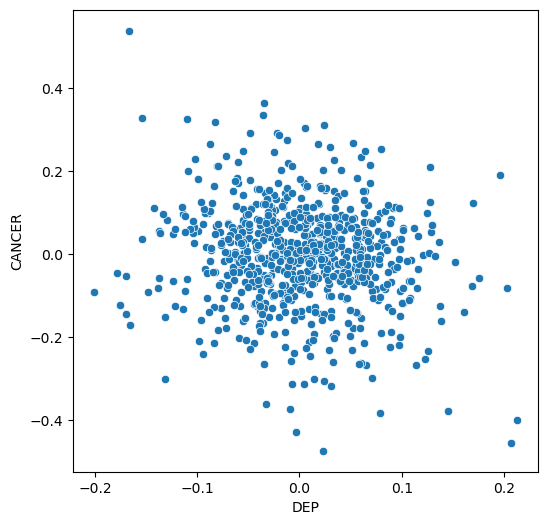

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


dfp = df.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()

plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=df_cleaned, 
    x='DEP', 
    y='CANCER'
)


In [46]:
pc_result = run_pc_analysis(df, my_factors, alpha=0.05, shuffle_factors=False, ci_test='spearman')

(874, 6)
Learned skeleton (CPDAG):


In [47]:
pc_result = run_pc_all_order(df, my_factors, alpha=0.05, ci_test='spearman',
                     stability_threshold=0.5, verbose=False)

(874, 6)
['DEP', 'ED', 'PI', 'MHP', 'GDP', 'NOI']
[(0, 1, [], 0.040334480306548535, 0.23357262051680597), (0, 2, [], 0.06341682085087214, 0.06092683492589132), (0, 3, [], 0.10576288322779158, 0.001741940175602756), (0, 4, [], -0.13455186150045664, 6.599306407405642e-05), (0, 5, [], 0.007194346242118069, 0.8318040753372135), (1, 2, [], -0.3892698757202284, 5.29475952994435e-33), (1, 3, [], -0.010353314932333074, 0.7598709344344251), (1, 4, [], 0.1309259253018247, 0.00010368246432455244), (1, 5, [], -0.03623240980083558, 0.28463062125572275), (2, 3, [], -0.16178189085443326, 1.5267851482684619e-06), (2, 4, [], -0.17583694781552717, 1.6793216463548113e-07), (2, 5, [], 0.08533321650158565, 0.011611314113545901), (3, 4, [], 0.036825214088560716, 0.2768191284197658), (3, 5, [], 0.08629630553299429, 0.010700464386083646), (4, 5, [], 0.10766970316872414, 0.0014335568082753348), (0, 3, [4], 0.11002472564198484, 0.00112217961826163), (0, 4, [3], -0.13747076791036308, 4.548853003149581e-05), (1, 

/var/folders/xn/k3tchqyx5bn081b3tlx0k4940000gn/T/ipykernel_8139/2307504936.py:93: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


---

In [25]:
records = []
for (x_idx, y_idx,cond_indices,corr, p_val ) in pc_result:
    # Convert x_idx and y_idx to factor names:
    x_name = my_factors[x_idx]
    y_name = my_factors[y_idx]
    # Convert conditioning indices (if any) to factor names:
    cond_names = [my_factors[z] for z in cond_indices]

    records.append({
        "X": x_name,
        "Y": y_name,
        "Z":  cond_names,
        "Spearman":corr,
        "p value": p_val
    })

df = pd.DataFrame(records)


In [26]:
df

,X,Y,Z,Spearman,p value
0,DEP,ED,[],0.040334,2.335726e-01
1,DEP,PI,[],0.063417,6.092683e-02
2,DEP,MHP,[],0.105763,1.741940e-03
3,DEP,GDP,[],-0.134552,6.599306e-05
4,DEP,NOI,[],0.007194,8.318041e-01
...,...,...,...,...,...
126,NOI,unemployment,"[MHP, GDP, CANCER]",0.174000,2.264322e-07
127,PI,MHP,"[ED, GDP, CANCER, unemployment]",-0.179727,8.826299e-08
128,PI,GDP,"[ED, MHP, CANCER, unemployment]",-0.147849,1.139744e-05
129,PI,CANCER,"[ED, MHP, GDP, unemployment]",-0.215100,1.315471e-10


In [ ]:
df.to_csv("../05_result/pc_result_0909.csv",index=False)

In [ ]:
import pandas as pd
import ast

# Load your CSV
df = pd.read_csv("../05_result/pc_result_0909.csv")


# Clean Z column
def clean_z(z):
    try:
        items = ast.literal_eval(z)
        if isinstance(items, list) and len(items) == 0:
            return '-'
        elif isinstance(items, list):
            return ', '.join(str(i) for i in items)
    except:
        return z
    return z

# Apply formatting
df['Z'] = df['Z'].apply(clean_z)
df['Spearman'] = df['Spearman'].astype(float).apply(lambda x: f"{x:.3f}")
df['p value'] = df['p value'].astype(float).apply(lambda x: r"\textless{} 0.001" if x < 0.001 else f"{x:.3f}")
# Apply italics formatting
for col in ["X", "Y", "Z"]:
    df[col] = df[col].apply(lambda v: f"\\textit{{{v}}}")

# Split side by side
half = len(df) // 2 + len(df) % 2
df1 = df.iloc[:half].reset_index(drop=True)
df2 = df.iloc[half:].reset_index(drop=True)
combined = pd.concat([df1, df2], axis=1)
combined.columns = ['X', 'Y', 'Z', 'Spearman', 'p value', 'X', 'Y', 'Z', 'Spearman', 'p value']

# Export to LaTeX
latex_code = combined.to_latex(
    index=False,
    column_format="lllrr|lllrr",
    escape=False
)

In [ ]:
with open("../05_result/pc_result_table.tex", "w") as f:
    f.write(latex_code)